In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.conv_learner import *
from fastai.text import *

In [4]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'

!ls {PATH}

20_words.csv	 multi_synth_words	paragraphs.tar.gz      words
ascii		 multi_synth_words.csv	synth_words	       words_chars.csv
chars.csv	 multi_synth_words.tgz	synth_words_50000.csv  words.csv
line_labels.csv  paragraph_chars.csv	synth_words.csv        words.tgz
lines		 paragraphs		tmp
lines.tgz	 paragraphs.csv		word_char_ids.csv
models		 paragraphs_df.csv	word_labels.csv


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Helper Functions

In [32]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[i] for i in ints])

In [37]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    if title: ax.set_title(title)
    return ax

# ModelData Object

In [6]:
# same as used in single word / multi-word
itos = pickle.load(open(TMP_PATH/'char_itos.pkl', 'rb'))

### 3x1 CSV

In [7]:
# CSV = PATH/'multi_synth_words.csv'
CSV = PATH/'synth_words_50000.csv'

# csv.to_csv(CSV, columns=['filename', 'char_ids'], index=False)
csv = pd.read_csv(CSV)
csv.head()

,filename,char_ids
0,000.png,68 70 74 75 1 71 60 70 71 67 60 1 59 64 74 58 3
1,001.png,75 63 60 68 1 70 58 58 76 73 74 1 59 73 64 60 ...
2,002.png,59 60 67 64 62 63 75 1 73 60 56 74 70 69 56 57...
3,003.png,75 63 60 80 1 56 61 75 60 73 1 73 60 56 59 80 3
4,004.png,58 63 70 74 60 69 1 56 67 56 73 68 60 59 1 56 ...


In [25]:
# length of longest string -> seq_len
csv.char_ids.map(lambda x: len(x.split(' '))).mean()
# 3x1
# max: 51
# mean: 22

21.54622

### 3x2 CSV

In [55]:
# CSV = PATH/'multi_synth_words.csv'
CSV = PATH/'multi_synth_words_50000.csv'

# csv.to_csv(CSV, columns=['filename', 'char_ids'], index=False)
csv = pd.read_csv(CSV)
csv.tail()

,filename,char_ids
49995,49995.png,75 63 56 69 1 58 70 69 77 60 69 75 64 70 69 56...
49996,49996.png,61 70 73 58 60 74 1 75 63 73 70 76 62 63 1 78 ...
49997,49997.png,74 67 64 62 63 75 1 71 60 56 67 1 42 56 73 66 ...
49998,49998.png,41 76 58 56 74 1 44 58 75 70 57 60 73 1 57 73 ...
49999,49999.png,57 60 61 70 73 60 1 71 73 60 74 76 68 56 57 67...


In [43]:
# length of longest string -> seq_len
csv.char_ids.map(lambda x: len(x.split(' '))).mean()
# 3x2
# max: 73
# mean: 43

42.92952

### Get val_idxs

In [44]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

7500

### Preprocess (rotate, normalize)

In [45]:
f = resnet34
sz = 128
bs = 50
pad_token = 0

In [66]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'multi_synth_words', CSV, bs=bs, val_idxs=val_idxs, 
                                    tfms=tfms, continuous=True)

In [67]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

### View image transforms

In [58]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


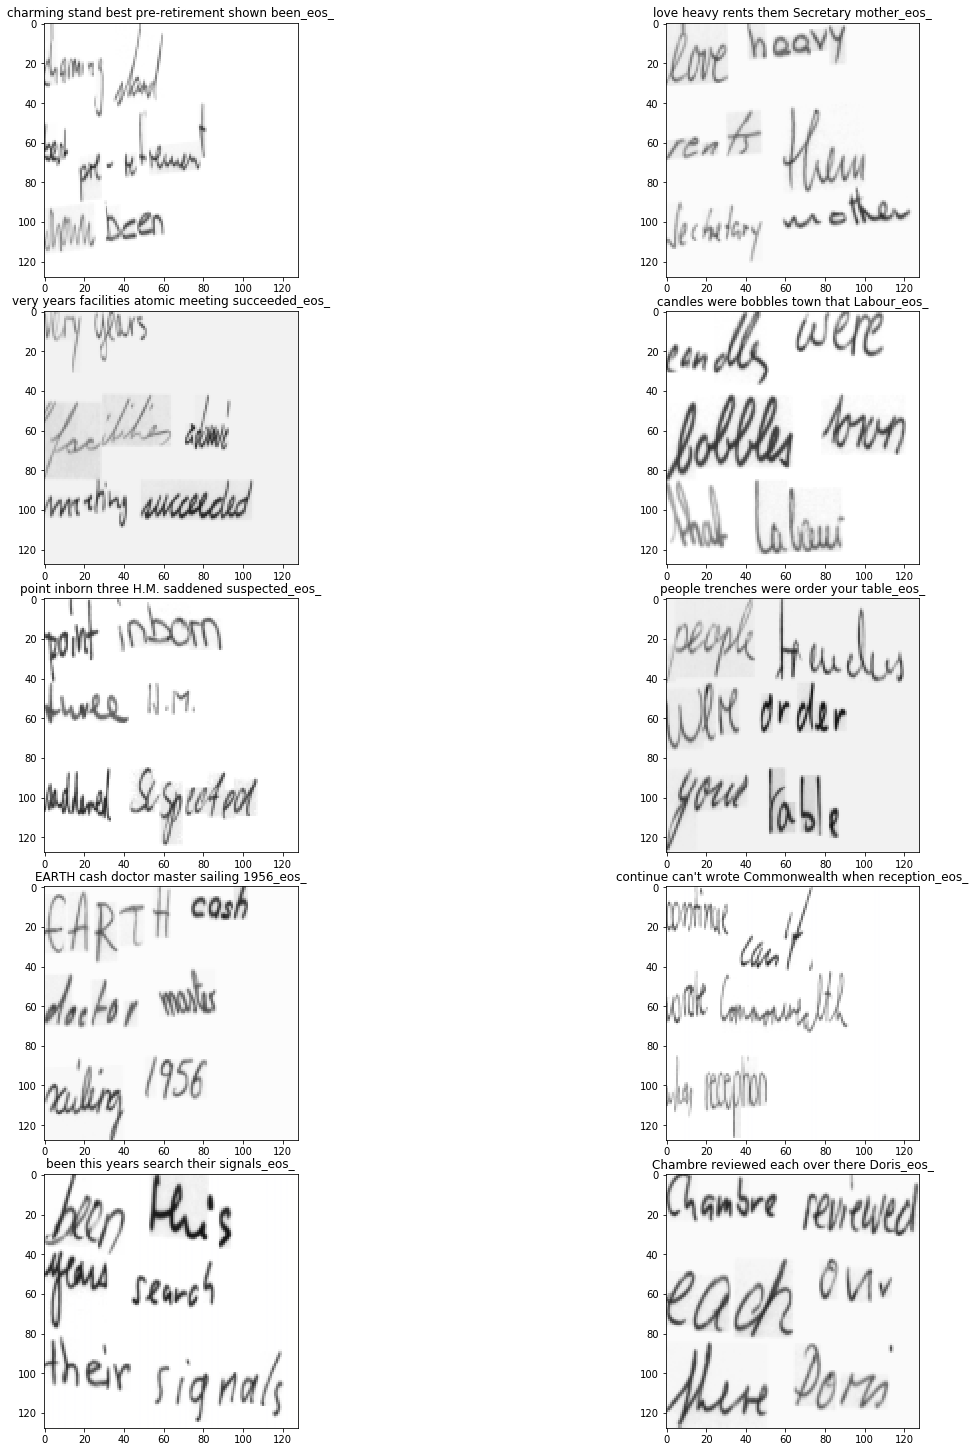

In [59]:
fig, axes = plt.subplots(5,2, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])
#     t = data.classes[y[i]]
    ax=show_img(x[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

# Loss and Metrics

In [13]:
# categorical cross entropy loss
# list of probabilities for each word in vocab; target is correct word

def seq2seq_loss(input, target):
    target = target.permute(1,0).contiguous()
    tsl = target.size(0)
    sl,bs,nc = input.size()
    
    if sl>tsl: target = F.pad(target, (0,0,0,sl-tsl))
    if tsl>sl: target = target[:sl]
        
    targ = target.view(-1)
    pred = input.view(-1, nc)

    # combination of LogSoftmax and NLLLoss
    return F.cross_entropy(pred, targ.long(), reduction='sum')/bs

In [14]:
import Levenshtein as Lev

# pulled from Sean Nareen's deepspeech decoder module
# https://github.com/SeanNaren/deepspeech.pytorch/blob/master/decoder.py

def cer(t, p):
    """
    Computes the Character Error Rate, defined as the edit distance.
    Arguments:
        t (string): target space-separated sentence
        p (string): prediction space-separated sentence
    """
    t, p, = t.replace(' ', ''), p.replace(' ', '')
    return Lev.distance(t, p)/len(t)

def wer(s1, s2):
    """
    Computes the Word Error Rate, defined as the edit distance between the
    two provided sentences after tokenizing to words.
    Arguments:
        s1 (string): space-separated sentence
        s2 (string): space-separated sentence
    """

    # build mapping of words to integers
    b = set(s1.split() + s2.split())
    word2char = dict(zip(b, range(len(b))))

    # map the words to a char array (Levenshtein packages only accepts
    # strings)
    w1 = [chr(word2char[w]) for w in s1.split()]
    w2 = [chr(word2char[w]) for w in s2.split()]

    return Lev.distance(''.join(w1), ''.join(w2))

In [28]:
def char_error_rate(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([sl, bs, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = label_text(res[:,i])
        t = label_text(targs[i])
        error += cer(t,p)
    return error/bs

# Architecture

In [16]:
class Encoder(nn.Module):
    def __init__(self, embed_size, drop=0.4):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[embed_size]
        
        net = f(True)
        modules = list(net.children())[:s]    #(8,8,256)
        self.base = nn.Sequential(*modules)
        
        #mlp
        self.drop = nn.Dropout(drop)
        self.linear1 = nn.Linear(embed_size, embed_size)
        self.linear2 = nn.Linear(embed_size, embed_size)
        
    def forward(self, inp):
        bs,nf,h,w = inp.size()
        
        features = self.base(inp)
        features = features.flatten(2, 3).permute(2, 0, 1)
        
        # initial hidden is an average of features fed through an MLP
        h = self.drop(features)
        h = self.linear2(F.relu(self.linear1(h))).mean(0)
                        
        return features, h

In [17]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, embed_size, drop=0.1):
        super().__init__()

        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.drop   = nn.Dropout(drop)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, hidden, feats):
        # this is called once for each timestep
        w1e = self.attn_1(feats)                    # ([64, 30, 256])
        w2h = self.attn_2(hidden)                   # ([30, 256])
        u = torch.tanh(w1e + w2h)                   # ([64, 30, 256])
        u = self.drop(u)
        a = torch.softmax(u @ self.attn_v, 0)       # ([64, 30]) - attention mask
        context = (a.unsqueeze(2) * feats).sum(0)   # ([30, 256]) - weighted sum of features w/ attention
        
        return context, a

In [18]:
class RNNDecoder(nn.Module):
    def __init__(self, embed_size, num_layers, drop=0.3):
        super().__init__()
        
        self.num_layers = num_layers
        self.rnn = nn.GRU(embed_size, embed_size, num_layers)
        if self.num_layers > 1: self.rnn.dropout = drop

    def forward(self, hidden, context):
        _, h = self.rnn(context.unsqueeze(0), hidden.expand(self.num_layers, -1, -1).contiguous())
        
        return h[-1]

In [19]:
class DeepOutputLayer(nn.Module):
    def __init__(self, embed_size, vocab_size, drop=0.3):
        super().__init__()
        
        self.w0 = nn.Linear(embed_size, embed_size)
        self.w1 = nn.Linear(embed_size, embed_size)
        self.w2 = nn.Linear(embed_size, embed_size)
        self.w3 = nn.Linear(embed_size*3, vocab_size)
        self.drop = nn.Dropout(drop)
        
    def forward(self, prev, hidden, context):
        # this is called once for each timestep
        #(30,256)
        a = self.w0(prev)
        b = self.w1(hidden)
        c = self.w2(context)
        out = torch.cat([a,b,c], 1)
        
        return self.w3(self.drop(out))

In [29]:
class Net(nn.Module):
    def __init__(self, hidden_size, vocab_size, seq_len, n_layers=1, drop=0.2):
        super(Net, self).__init__()
        self.seq_len = seq_len
        
        self.encoder = Encoder(hidden_size)
        self.attention = Attention(hidden_size)
        self.decoder = RNNDecoder(hidden_size, n_layers)
        
        self.embed   = nn.Embedding(vocab_size, hidden_size)
        self.drop    = nn.Dropout(drop)
        self.embed.weight.data.uniform_(-0.1, 0.1)

        self.output  = DeepOutputLayer(hidden_size, vocab_size)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats, hidden = self.encoder(x)
        
        res,attns = [],[]
        dec_inp = torch.ones(bs, device=device).long()
        
        for i in range(self.seq_len):
            prev = self.drop(self.embed(dec_inp))
            
            context, a = self.attention(hidden, feats)
            hidden = self.decoder(hidden, context)
            out = self.output(prev, hidden, context)
            
            res.append(out)
            attns.append(a)
            dec_inp = out.data.max(1)[1]    # greedy decoder (return max value)
            if (dec_inp==pad_token).all(): break
        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

In [60]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(256, len(itos), 75, 1)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [char_error_rate]

# Training

In [44]:
# preload single word
learn.load('256_2')

In [61]:
# preload 3x1
learn.load('3x1_preloaded_256')

In [62]:
lr=1e-3
learn.fit(lr, 1, cycle_len=1)
# vanilla 3x2
# 136.716545 0.869386

# 3x1 preloading single weights (sz: 128, bs: 50)
# 35.113448  33.608538  0.325035

# 3x2 preloading 3x1 weights (sz: 128, bs: 50)
# 99.874218  0.594965               - 10,000, preloaded only 3x1 (not full preloading from single), seq_len 50
# 105.012106 102.127445 0.627175    - 50,000, full preloading from single, seq_len 75

epoch      trn_loss   val_loss   char_error_rate             
    0      105.012106 102.127445 0.627175  



[102.12744506835938, 0.6271750522143474]

In [63]:
lr=1e-3
learn.fit(lr, 5, cycle_len=1, use_clr=(10, 4))
# vanilla 3x2
# 132.80176  131.863912  0.808793 

# 3x1 preloading single weights (sz: 128, bs: 50)
# 19.535989  21.528007  0.155451

# 3x2 preloading 3x1 weights
# 86.732118  92.116078  0.497685    - 10,000, preloaded only 3x1 (not full preloading from single), seq_len 50
# 81.668771  84.472149  0.470295    - 50,000, full preloading from single, seq_len 75

epoch      trn_loss   val_loss   char_error_rate             
    0      97.530017  96.246377  0.583458  
    1      92.410731  91.50468   0.536989                    
    2      89.022028  89.175125  0.52136                     
    3      85.601055  86.469216  0.485001                    
    4      81.668771  84.472149  0.470295                    



[84.4721485900879, 0.4702954147979853]

In [64]:
# learn.save('3x1_preloaded_1')
learn.save('3x2_preloaded_128')

## Resize

In [65]:
sz = 256
bs = 30

In [68]:
learn.set_data(data)

In [69]:
learn.fit(lr, 5, cycle_len=1, use_clr=(10,4))
# 3x1 preloading single weights (sz: 256, bs: 30)
# 13.140219  13.990765  0.084631

# 3x2 preloading 3x1 weights
# 52.448398  55.614853  0.236137    - 10,000, preloaded only 3x1 (not full preloading from single), seq_len 50
# 46.021139  49.239335  0.165624    - 50,000, full preloading from single, seq_len 75

epoch      trn_loss   val_loss   char_error_rate              
    0      59.444094  56.030432  0.253286  
    1      54.899185  53.645362  0.235033                     
    2      52.273837  51.517822  0.203947                     
    3      50.242098  49.839115  0.20063                      
    4      46.021139  49.239335  0.165624                     



[49.23933522796631, 0.16562396030650933]

In [70]:
# learn.save('3x1_preloaded_256')
learn.save('3x2_preloaded_256')

# Previous training

In [33]:
learn.fit(lr, 10, cycle_len=1, use_clr=(20, 8))
# vanilla
# 115.391809 114.97687  0.673306

epoch      trn_loss   val_loss   char_error_rate           
    0      131.163149 130.673215 0.776042  
    1      131.003323 129.395992 0.764182                  
    2      129.526969 128.725048 0.761507                  
    3      128.765353 127.721173 0.755929                  
    4      127.769132 126.09784  0.740478                  
    5      125.878682 124.774431 0.748479                  
    6      123.701167 121.935554 0.716089                  
    7      120.865392 119.592112 0.707619                  
    8      118.274451 117.219771 0.696522                  
    9      115.391809 114.97687  0.673306                  



[114.97686950683594, 0.6733063989712456]

In [185]:
learn.save('3x2_128_preloaded_cer50')
# learn.save('multi_synth_16epochs')

### update saved model parameter names

In [51]:
sd = torch.load(PATH/'models/50000_deep_concat_14epochs.h5', map_location=lambda storage, loc: storage)

In [54]:
sd["attention.attn_v"] = sd.pop("decoder.attn_v")
sd["attention.attn_1.weight"] = sd.pop("decoder.attn_1.weight")
sd["attention.attn_1.bias"] = sd.pop("decoder.attn_1.bias")
sd["attention.attn_2.weight"] = sd.pop("decoder.attn_2.weight")
sd["attention.attn_2.bias"] = sd.pop("decoder.attn_2.bias")
sd["decoder.rnn.weight_ih_l0"] = sd.pop("decoder.dec_rnn.weight_ih_l0")
sd["decoder.rnn.weight_hh_l0"] = sd.pop("decoder.dec_rnn.weight_hh_l0")
sd["decoder.rnn.bias_ih_l0"] = sd.pop("decoder.dec_rnn.bias_ih_l0")
sd["decoder.rnn.bias_hh_l0"] = sd.pop("decoder.dec_rnn.bias_hh_l0")

In [55]:
torch.save(sd, PATH/'models/50000_deep_concat_14epochs_mod.h5')

In [166]:
learn.load('50000_deep_concat_14epochs_mod')   # show_attend_tell 3x1 synth words

## Increase data size

In [186]:
# resize data
sz = 256

# NOTE: re-run preprocessing cells after changing this

In [189]:
learn.set_data(data)

In [190]:
lr=1e-3
learn.fit(lr, 5, cycle_len=1, use_clr=(10, 4))
# vanilla
# 100.503429 99.639416  0.57183

# preloading 3x1 weights
# 52.448398  55.614853  0.236137

epoch      trn_loss   val_loss   char_error_rate            
    0      69.453592  62.868943  0.337165  
    1      62.719914  58.27796   0.29334                    
    2      57.718084  56.047147  0.268812                   
    3      54.300116  54.346611  0.247935                   
    4      52.448398  55.614853  0.236137                   



[55.614852600097656, 0.2361370208231086]

In [191]:
learn.save('3x2_256_preloaded_cer23')
# learn.save('256_multi_synth_21epochs')

In [68]:
learn.fit(lr, 10, cycle_len=1, use_clr=(20, 8))
# vanilla
# 73.640913  84.395193  0.416838

epoch      trn_loss   val_loss   char_error_rate            
    0      96.896304  97.197401  0.549884  
    1      93.915499  96.241492  0.533602                   
    2      90.566493  93.035763  0.519517                   
    3      87.280741  91.61761   0.502912                   
    4      84.80345   90.023858  0.4846                     
    5      81.998173  89.013988  0.465966                   
    6      79.581904  88.312173  0.460483                   
    7      77.772685  86.308966  0.447388                   
    8      75.608696  85.036784  0.429607                   
    9      73.640913  84.395193  0.416838                   



[84.39519287109376, 0.41683790064652637]

In [69]:
learn.save('256_multi_synth_31epochs')

In [70]:
learn.fit(lr, 10, cycle_len=1, use_clr=(20, 8))
# vanilla
# 57.173106  76.512565  0.31721

epoch      trn_loss   val_loss   char_error_rate            
    0      71.943404  82.140365  0.405925  
    1      69.495107  82.218144  0.393748                   
    2      67.26007   81.081586  0.379274                   
    3      66.389284  80.321962  0.365812                   
    4      64.702705  78.772724  0.366751                   
    5      64.122691  78.196216  0.35374                    
    6      61.135725  78.377035  0.343291                   
    7      59.731121  77.378957  0.331724                   
    8      59.690751  78.056312  0.324922                   
    9      57.173106  76.512565  0.31721                    



[76.51256538391114, 0.3172099898886025]

In [71]:
learn.save('256_multi_synth_41epochs')

# Results

In [22]:
learn.load('3x2_preloaded_256')

In [71]:
x,y = next(iter(data.val_dl))
learn.model.eval()
preds,attns = learn.model(x, ret_attn=True)   #attns ([sl, 256, bs])
res = torch.argmax(preds, dim=-1)

seq2seq_loss(preds, y)

tensor(50.2479, device='cuda:0', grad_fn=<DivBackward0>)

In [72]:
char_error_rate(preds, y)

0.19464422006522641

## Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


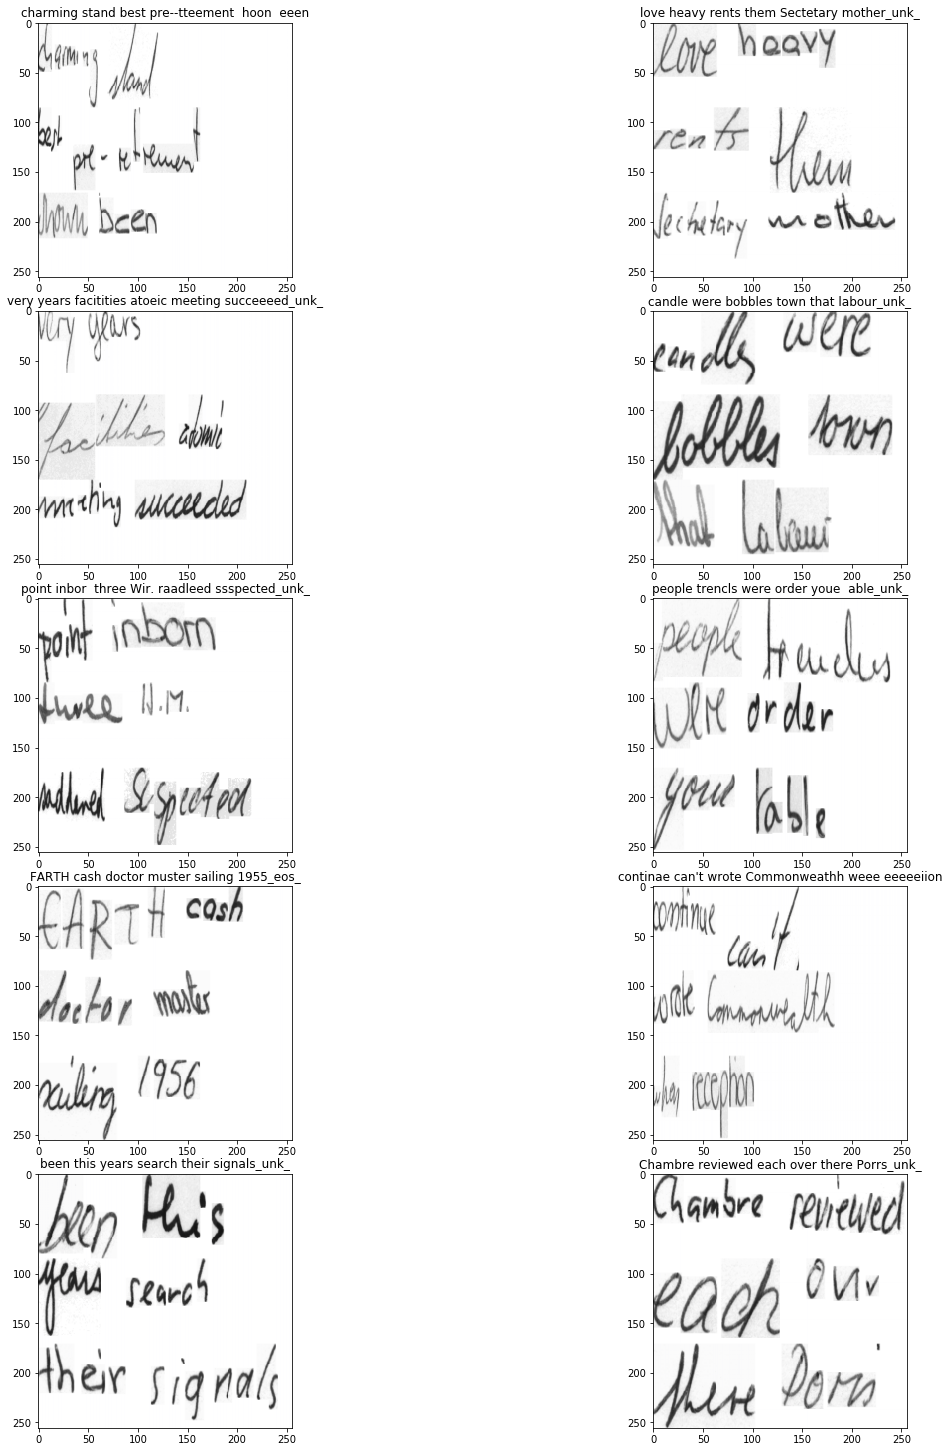

In [73]:
imgs = data.trn_ds.denorm(x)

fig, axes = plt.subplots(5,2, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])     #=>  char indices
    p = label_text(res[:,i])
    ax=show_img(imgs[i], ax=ax, title=p)#t+' '+p)
    
plt.tight_layout(pad=0.1)

## Attention

In [108]:
def torch_scale_attns(attns):
    sl,_,bs = attns.shape
    num = sz // 16
    mod = attns.permute(2,0,1).view(bs,sl,num,num)
    scaled = torch.nn.functional.interpolate(mod, size=sz)
    return scaled  #([bs, sl, sz, sz])

In [112]:
from scipy.ndimage import gaussian_filter

# def scale_attn_to_img(att, k=16):
#     num = sz // 16
#     a = att.reshape(num,num)
#     a = np.repeat(np.repeat(a,16, axis=0), 16, axis=1)   # upsample att to match img size
#     a = gaussian_filter(a, sigma=k)                      # apply gaussian filter (blurs into circle)
#     return a

def g_filter(att, k=16):
    return gaussian_filter(att, sigma=k)

In [109]:
idx  = 1
img  = imgs[idx]
pred = res[:,idx]
img_attns = to_np(torch_scale_attns(attns)[idx])
# img_attns = to_np(attns[:,:,idx])   # first batch

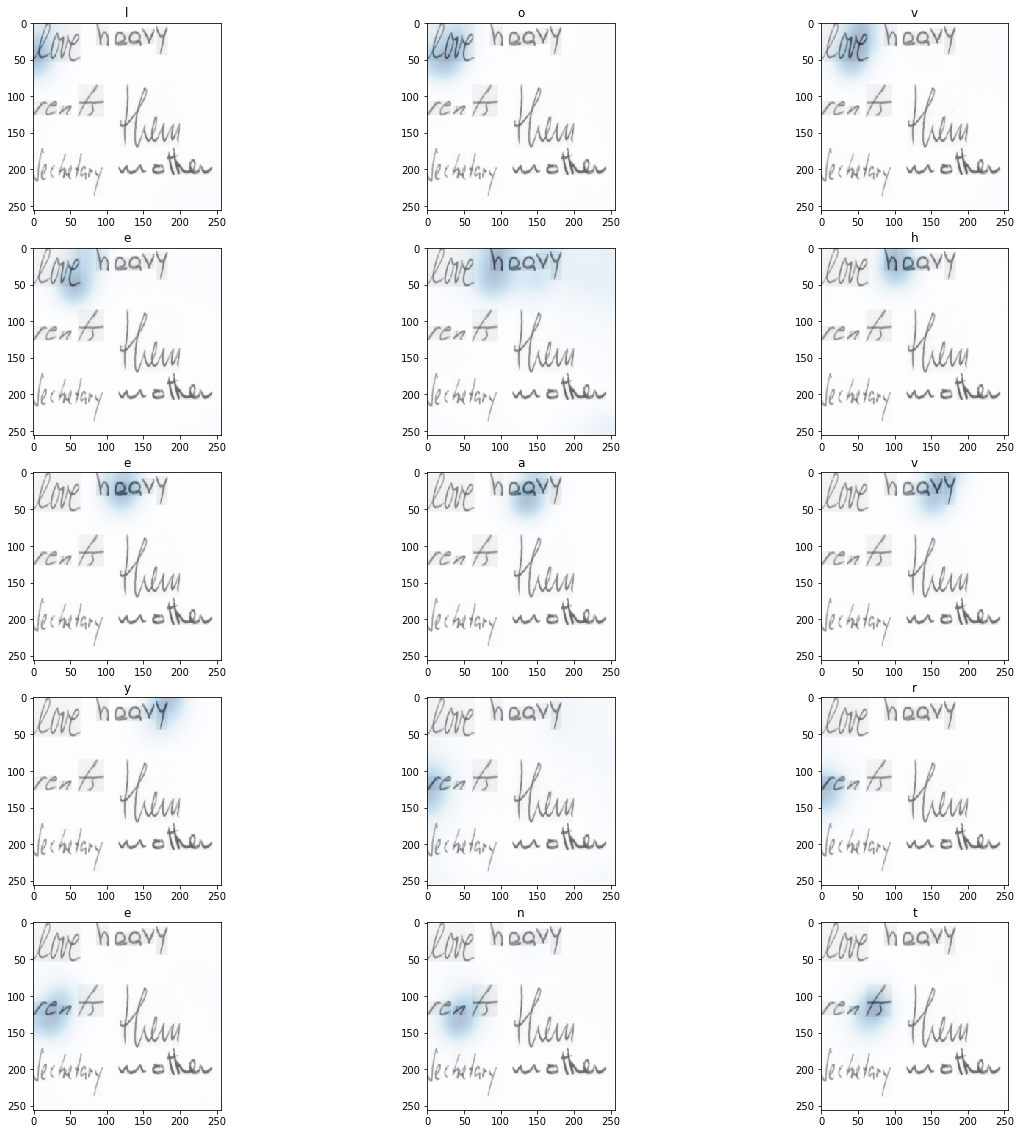

In [113]:
fig, axes = plt.subplots(5, 3, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
#     a = scale_attn_to_img(attn[i])
    a = g_filter(img_attns[i])
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', interpolation='nearest', alpha=0.3)
    ax.set_title(itos[pred[i].item()])

# Experimental beam search

In [64]:
preds.shape

torch.Size([50, 30, 82])

In [81]:
itos[torch.argmax(preds[9,1])]

'm'

In [82]:
preds[9,1]

tensor([ -1.7871,   0.3833, -13.8656,  -2.3820, -13.7671,  -9.1410, -13.9103,
        -13.7915,  -5.0735, -13.8421, -13.6709,  -9.5398, -14.3628,  -9.2688,
         -1.4600,  -4.3306, -11.6178,  -5.6748,  -8.7802,  -8.2158,  -9.1550,
         -6.6994,  -9.2702,  -7.8610,  -7.8643, -11.5539, -11.0650, -13.6558,
        -13.7375, -10.2518,  -0.3875,  -5.2782,  -0.7480,  -3.6194,  -1.8601,
         -5.1097,  -2.7695,  -2.6276,  -3.2573,  -4.0469,  -5.5239,  -2.5854,
         -0.6695,  -2.3796,  -2.1205,  -3.9475,  -3.5157,  -4.6824,  -2.8357,
         -3.4824,  -1.2213,  -7.3033,  -2.8341, -10.6099,  -3.1855,  -7.3634,
          2.4667,  -2.2037,   1.4976,   0.0436,   2.9012,  -1.9311,  -2.1138,
         -1.5034,  -0.1693,  -6.8526,  -1.5504,   0.5846,   5.3692,   3.8683,
          0.9259,  -1.9507,  -2.5749,   1.1827,  -0.2156,  -0.2136,   3.2035,
         -1.2014,   1.6209,  -3.3789,  -0.1157,  -6.0245],
       device='cuda:0', grad_fn=<SelectBackward>)

In [85]:
amts, idxs = torch.topk(preds[10,1], 5)
amts, idxs

(tensor([4.5526, 4.1031, 3.2854, 3.0571, 2.4000],
        device='cuda:0', grad_fn=<TopkBackward>),
 tensor([68, 69, 76, 60, 56], device='cuda:0'))

In [86]:
[itos[i] for i in idxs]

['m', 'n', 'u', 'e', 'a']